In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt


In [22]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from mixture_lower import Mixture
from guided_models import Diffusion, GuidedDiffusion, LastStepDiffusion
from mixture_guidance import MixtureSpecificGuidance
from chernoff_gpt import ChernoffGuidance
from value_estimator import ValueEstimate
from tv_estimator import tv_bounds_classifier

results = {}

# Diffusion parameters
n = T = 20
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta
d = 2

# Mixture setup
mu_0 = np.array([[5, 0], [-5, 0]])
var_0 = np.eye(d)
pi_0 = np.array([0.95, 0.05])
pi_0 /= np.sum(pi_0)
dist0 = Mixture(mu_0, var_0, pi_0)
diffusion_unguided = Diffusion(dist0, alpha_t, S=5000)
X_unguided = diffusion_unguided.calc_samples()
unguided_num_steps = T*5000

num_training_trials = 70_000
diffusion = Diffusion(dist0, alpha_t, S=num_training_trials)
X = diffusion.calc_samples()

# for B in [1, 3, 5, 9]:
for B in [1, 3, 5, 7]:
    print(f"\n=== Running for B = {B} ===")
    k = 2
    # def reward_func(x):
    #     x0 = np.asarray(x)[..., 0]
    #     return B / (1 + np.exp(k * (x0 + 8)))
    def reward_func_hard(x):
        x0 = np.asarray(x)[..., 0]
        return np.where(x0 < -7, B, 0)
    L_r = B * k / 4

    # Plot reward function
    x1 = np.linspace(-10, 10, 200)
    x2 = np.linspace(-5, 5, 200)
    X1, X2 = np.meshgrid(x1, x2)
    Z = reward_func_hard(np.stack([X1, X2], axis=-1))
    plt.figure(figsize=(6, 4))
    plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
    plt.colorbar(label='reward_func(x)')
    plt.title(f'Step Function Visualization (B={B})')
    plt.show()

    expr = np.exp(reward_func_hard(X[:, -1, :]))
    plt.plot(expr)
    plt.title(f"Reward Expression (B={B})")
    plt.show()

    # Train value estimator
    val_ensemble = ValueEstimate(X, expr, [128, 500, 500])
    val_ensemble.train()

    # Guided sampling
    guided_per = GuidedDiffusion(
        dist0, alpha_t,
        lambda x, t: np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B)),
        upper_bound=B, temperature=1, S=5000
    )
    X_per = guided_per.calc_samples()

    guided_true = LastStepDiffusion(
        dist0, alpha_t,
        lambda x: np.log(np.clip(reward_func_hard(x), np.e**(-B), np.e**B)),
        upper_bound=B, S=5000
    )
    X_guided_true = guided_true.calc_samples()

    def func(x, val_ensemble):
        x = np.expand_dims(x, axis=0)
        t_arr = np.array([T - 1])
        return np.log(val_ensemble.predict(x, t_arr))

    guided_last = LastStepDiffusion(
        dist0, alpha_t,
        lambda x: func(np.array(x), val_ensemble),
        upper_bound=B, S=5000
    )
    X_guided_last = guided_last.calc_samples()

    guided_msg = MixtureSpecificGuidance(dist0, alpha_t, reward_func_hard, L_r = L_r, value_fn=lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))),   S = 5000, delta = 0.01, use_trace = False)
    X_guided_msg = guided_msg.calc_samples()

    guided_chern = ChernoffGuidance(dist0, alpha_t, lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))), S = 5000,  iters = 400, fix_lambda=False, verbose = False)
    X_guided_chern = guided_chern.train_baselines_and_sample(lam_init = 15)

    num_steps_msg = guided_msg.num_steps
    num_steps_per = guided_per.num_steps
    num_steps_true = guided_true.num_steps
    num_steps_last = guided_last.num_steps
    num_steps_chern = guided_chern.num_steps

    # TV distance estimates
    tv_per = tv_bounds_classifier(X[:, -1, :], X_per[:, -1, :])
    tv_true = tv_bounds_classifier(X[:, -1, :], X_guided_true[:, -1, :])
    tv_last = tv_bounds_classifier(X[:, -1, :], X_guided_last[:, -1, :])
    tv_unguided = tv_bounds_classifier(X_unguided[:, -1, :], X_guided_true[:, -1, :])
    tv_chern = tv_bounds_classifier(X[:, -1, :], X_guided_chern[:, -1, :])

    results[B] = {
        "tv_per": tv_per,
        "tv_true": tv_true,
        "tv_last": tv_last,
        "tv_unguided": tv_unguided,
        "tv_chern": tv_chern,
        "X_guided_msg": X_guided_msg,
        "X_per": X_per,
        "X_guided_true": X_guided_true,
        "X_guided_last": X_guided_last,
        "X_unguided": X_unguided,
        "X_guided_chern": X_guided_chern,
        "num_steps_msg": num_steps_msg,
        "num_steps_per": num_steps_per,
        "num_steps_true": num_steps_true,
        "num_steps_last": num_steps_last,
        "num_steps_chern": num_steps_chern
    }

    # # Example: plot histograms for each B
    # plt.figure(figsize=(8, 6))
    # plt.hist(X[:, -1, 0], bins=100, alpha=0.5, color='green', label='H.P. Guided (per step)')
    # plt.hist(X_guided_last[:, -1, 0], bins=100, alpha=0.5, color='blue', label='Guided (last step)')
    # plt.hist(X_guided_true[:, -1, 0], bins=100, alpha=0.5, color='orange', label='True optimal')
    # plt.xlabel('First Coordinate')
    # plt.ylabel('Count')
    # plt.title(f'Superimposed Histogram of Final Step Samples (B={B})')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# After the loop, you can analyze or plot results for all B values
# for B in results:
#     print(f"\nB = {B}")
#     print("TV (per step):", results[B]["tv_per"]["tv_lb"])
#     print("TV (true):", results[B]["tv_true"]["tv_lb"])
#     print("TV (last step):", results[B]["tv_last"]["tv_lb"])
#     print("TV (unguided):", results[B]["tv_unguided"]["tv_lb"])

Reverse Diffusion Progress:   0%|          | 0/19 [1:03:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
        "X_guided_msg": X_guided_msg,
        "X_per": X_per,
        "X_guided_true": X_guided_true,
        "X_guided_last": X_guided_last,
        "X_unguided": X_unguided,
        "X_guided_chern": X_guided_chern,

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(25, 8), sharex=True, sharey=True)
axs = axs.flatten()  # flatten 2D grid to 1D for easier indexing

titles = [
    'Unaligned distribution',
    'True aligned distribution',
    'Per-step guidance',
    'Last-step guidance',
    'Mixture specific guidance (MSG)',
    'Chernoff guidance'
]
colors = ['green', 'blue', 'orange', 'orange', 'purple', 'red']
keys = ["X_unguided", "X_guided_true", "X_per", "X_guided_last", "X_guided_msg", "X_guided_chern"]

for i, (key, title, color) in enumerate(zip(keys, titles, colors)):
    axs[i].hist(results[3][key][:5000, -1, 0], bins=100, alpha=0.7, color=color)
    axs[i].set_title(title)
    axs[i].set_xlabel('First Coordinate')
    axs[i].set_ylabel('Count')

# Hide any unused subplots (last 4)
for j in range(len(keys), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(25, 4), sharex=True, sharey=True)

axs[0, 0].hist(results[3]["X_unguided"][:, -1, 0], bins=100, alpha=0.7, color='green')
axs[0, 0].set_title('Unaligned distribution')
axs[0, 0].set_xlabel('First Coordinate')
axs[0, 0].set_ylabel('Count')

axs[1, 0].hist(results[3]["X_guided_true"][:, -1, 0], bins=100, alpha=0.7, color='blue')
axs[1, 0].set_title('True aligned distribution')
axs[1, 0].set_xlabel('First Coordinate')

axs[2, 0].hist(results[3]["X_per"][:, -1, 0], bins=100, alpha=0.7, color='orange')
axs[2, 0].set_title('Per-step guidance')
axs[2, 0].set_xlabel('First Coordinate')

axs[3, 0].hist(results[3]["X_guided_last"][:, -1, 0], bins=100, alpha=0.7, color='orange')
axs[3, 0].set_title('Last-step guidance')
axs[3, 0].set_xlabel('First Coordinate')

axs[4, 0].hist(results[3]["X_guided_msg"][:, -1, 0], bins=100, alpha=0.7, color='purple')
axs[4, 0].set_title('Mixture specific guidance (MSG)')
axs[4, 0].set_xlabel('First Coordinate')

axs[5, 0].hist(results[3]["X_guided_chern"][:, -1, 0], bins=100, alpha=0.7, color='red')
axs[5, 0].set_title('Chernoff guidance')
axs[5, 0].set_xlabel('First Coordinate')

plt.tight_layout()
plt.show()

In [ ]:
results

In [29]:
import pickle

with open("results_vary_B_with_chernoff.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to results_vary_B_with_chernoff.pkl")

Results saved to results_vary_B_with_chernoff.pkl


In [30]:
import pickle

with open("results_vary_B_with_chernoff.pkl", "rb") as f:
    results_loaded = pickle.load(f)

# Now you can access results as before, e.g.:
print(results_loaded.keys())
print(results_loaded[1].keys())

dict_keys([1, 3, 5])
dict_keys(['tv_per', 'tv_true', 'tv_last', 'tv_unguided', 'tv_chern', 'X_guided_msg', 'X_per', 'X_guided_true', 'X_guided_last', 'X_unguided', 'X_guided_chern', 'num_steps_msg', 'num_steps_per', 'num_steps_true', 'num_steps_last', 'num_steps_chern'])


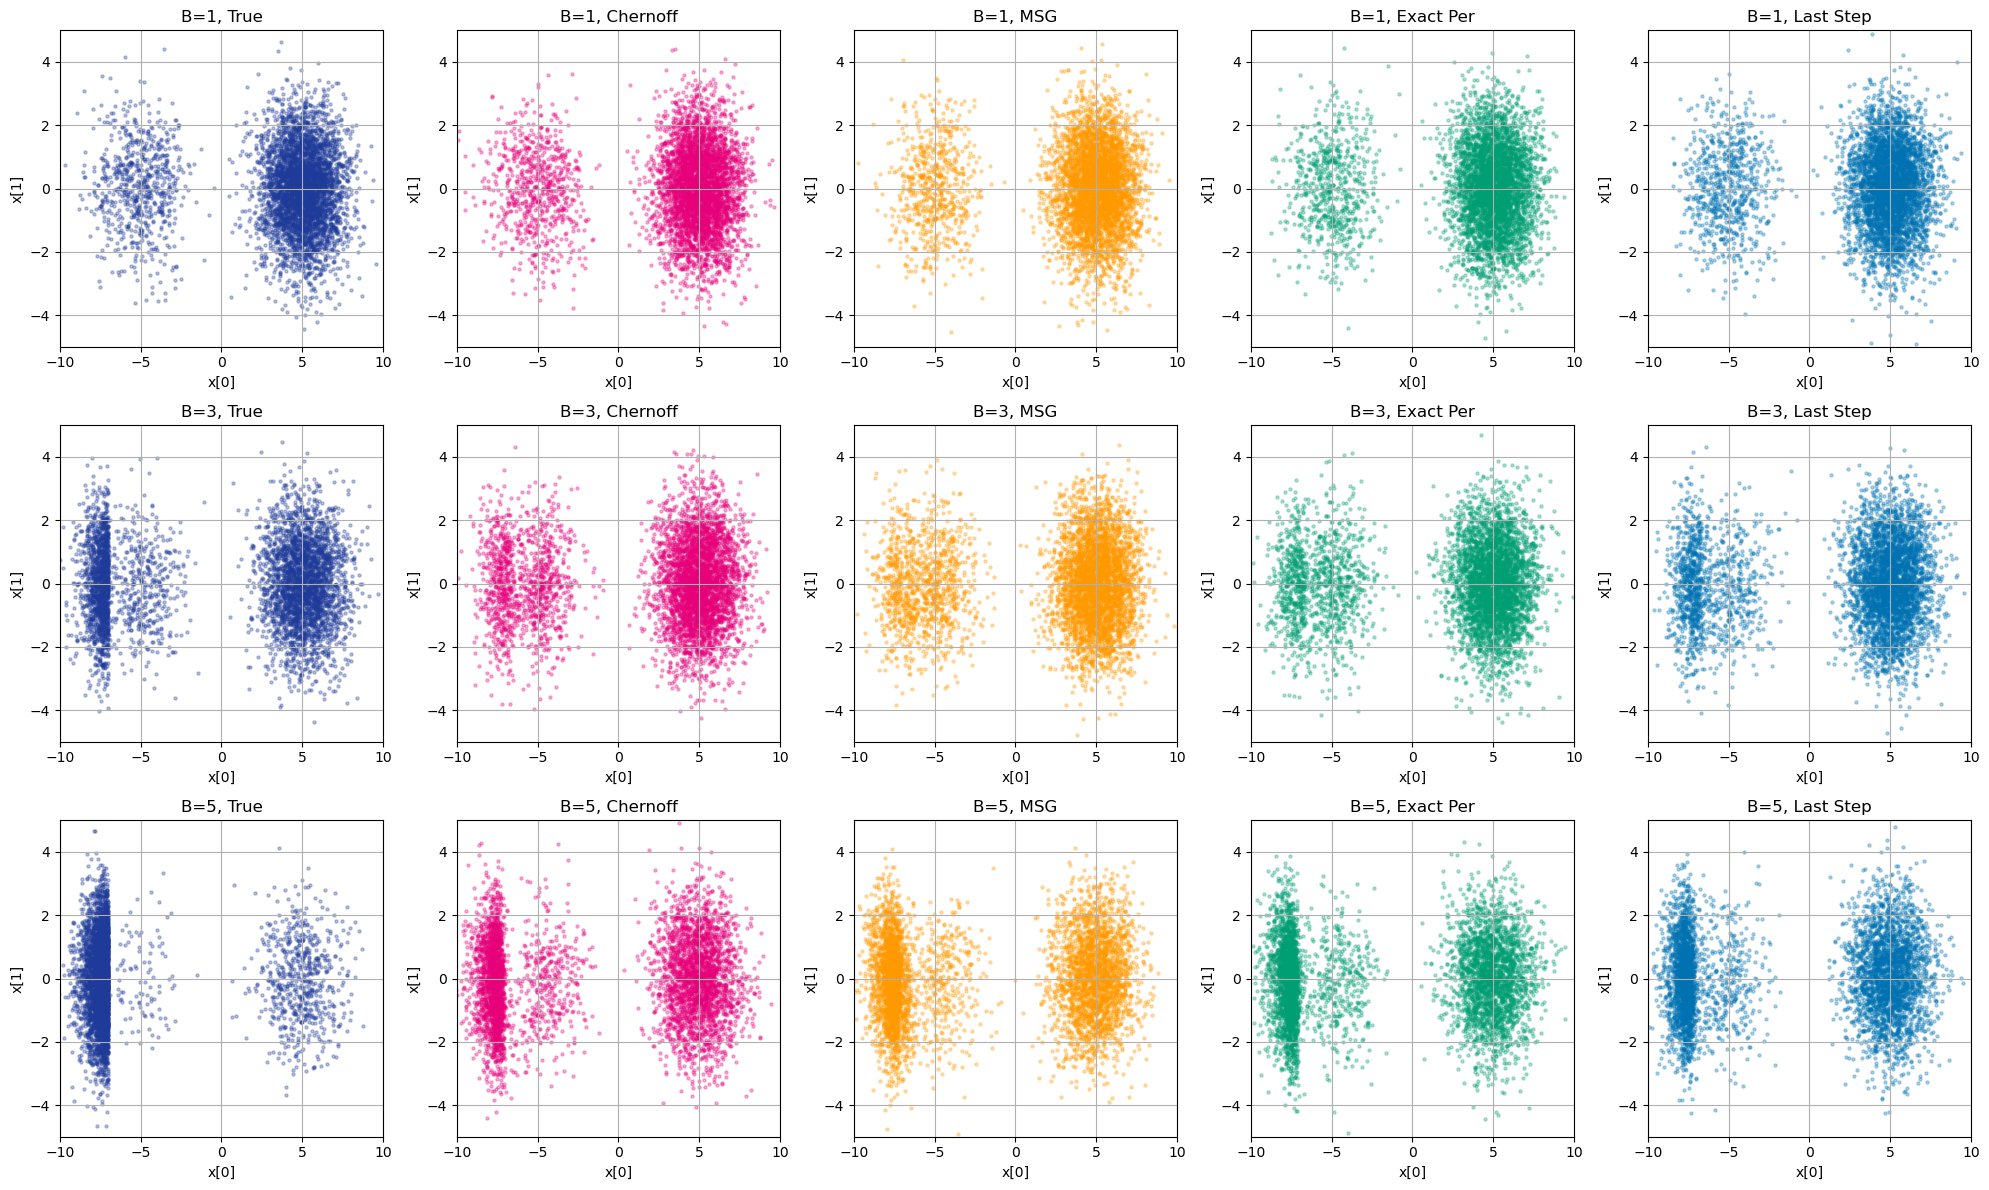

IndexError: index 4 is out of bounds for axis 1 with size 4

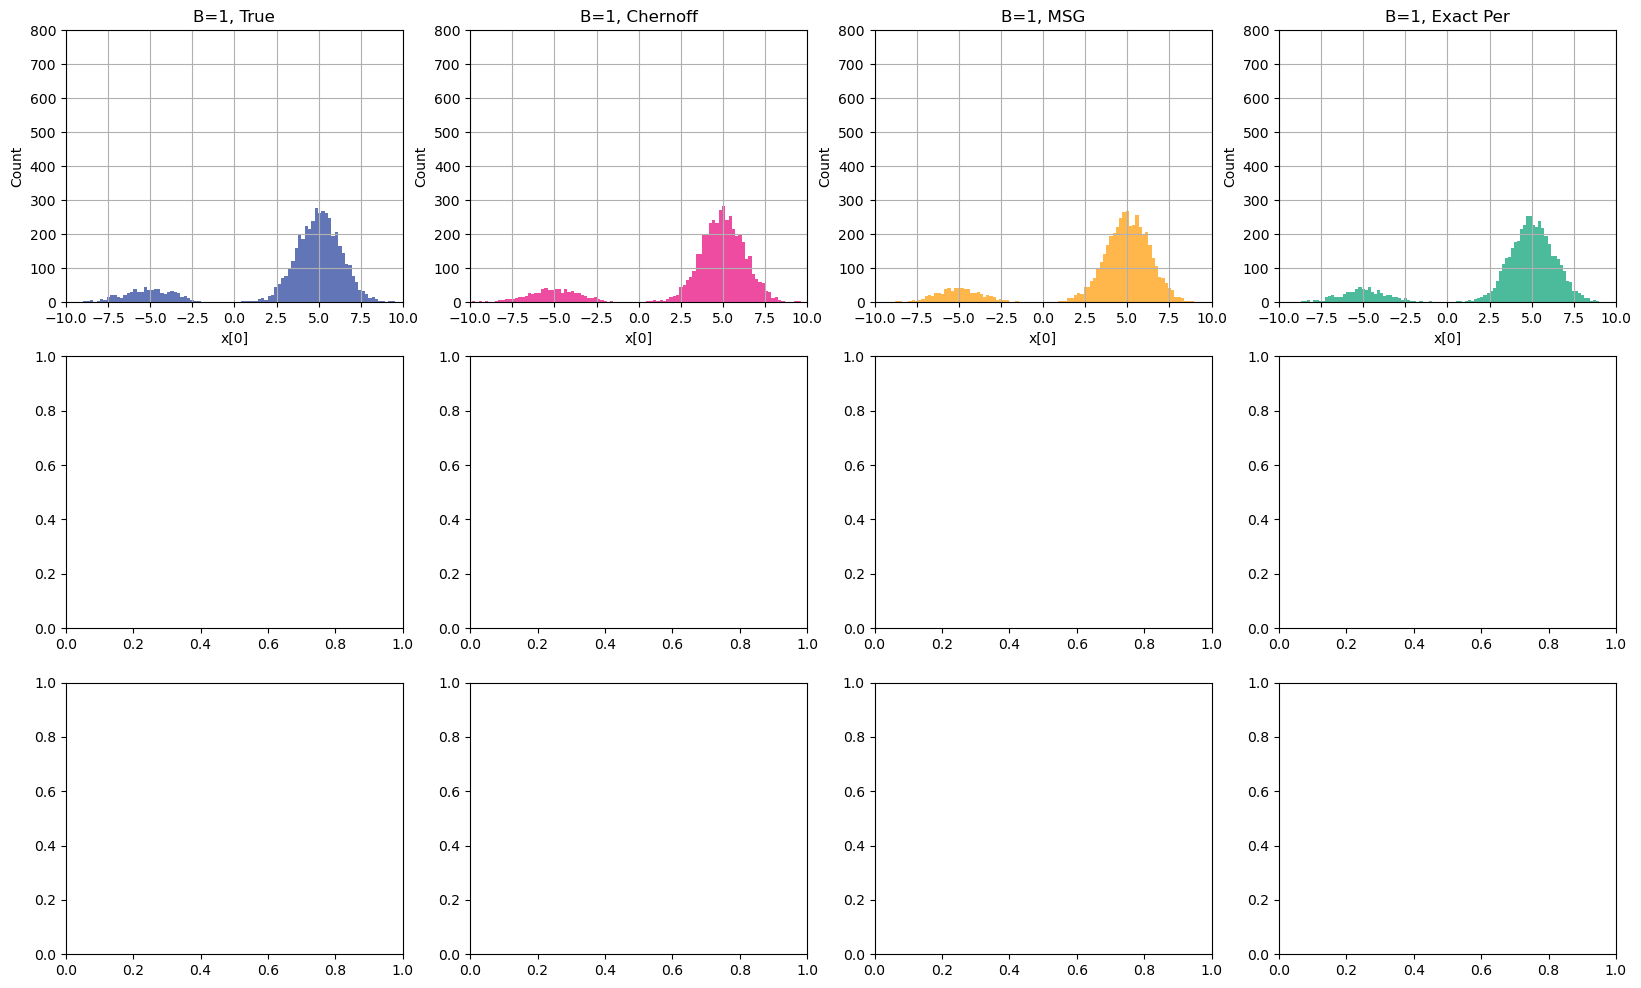

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
Bs = sorted(results_loaded.keys())
# guided_keys = ["X_per", "X_guided_last", "X_guided_true", "X_guided_msg"]
guided_keys = ["X_guided_true", "X_guided_chern", "X_guided_msg", "X_per", "X_guided_last"]
# guided_labels = ["True", "Chernoff", "MSG", "Exact Per"]
# guided_colors = ["blue", "red", "orange", "green"]

guided_info = {
    "X_guided_true":  {"label": "True",      "color": "#1f3b99"},   # navy
    "X_guided_last": {"label": "Last Step", "color": "#0072B2"},   # blue
    "X_guided_chern": {"label": "Chernoff",  "color": "#e6007a"},   # magenta (stands out)
    "X_guided_msg":   {"label": "MSG",       "color": "#ff9900"},   # orange
    "X_per":          {"label": "Exact Per", "color": "#009e73"},   # teal
}

xlim = (-10, 10)
ylim = (-5, 5)

for i, B in enumerate(Bs):
    for j, key in enumerate(guided_keys):
        X_samples = results_loaded[B][key][:, -1, :]
        axes[i, j].scatter(
            X_samples[:, 0], X_samples[:, 1],
            s=5, alpha=0.3,
            color=guided_info[key]["color"]
        )
        axes[i, j].set_title(f"B={B}, {guided_info[key]['label']}")
        axes[i, j].set_xlabel("x[0]")
        axes[i, j].set_ylabel("x[1]")
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
# Set common limits for histograms
hist_xlim = (-10, 10)
hist_ylim = (0, 800)  # Adjust as needed for your data

for i, B in enumerate(Bs):
    for j, key in enumerate(guided_keys):
        X_samples = results_loaded[B][key][:, -1, 0]
        axes[i, j].hist(
            X_samples, bins=100, alpha=0.7,
            color=guided_info[key]["color"]
        )
        axes[i, j].set_title(f"B={B}, {guided_info[key]['label']}")
        axes[i, j].set_xlabel("x[0]")
        axes[i, j].set_ylabel("Count")
        axes[i, j].set_xlim(hist_xlim)
        axes[i, j].set_ylim(hist_ylim)
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

# xlim = (-10, 10)
# ylim = (-5, 5)

# for i, B in enumerate(Bs):
#     for j, key in enumerate(guided_keys):
#         X_samples = results_loaded[B][key][:, -1, :]
#         axes[i, j].scatter(X_samples[:, 0], X_samples[:, 1], s=5, alpha=0.3, color=guided_colors[j])
#         axes[i, j].set_title(f"B={B}, {guided_labels[j]}")
#         axes[i, j].set_xlabel("x[0]")
#         axes[i, j].set_ylabel("x[1]")
#         axes[i, j].set_xlim(xlim)
#         axes[i, j].set_ylim(ylim)
#         axes[i, j].grid(True)

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(3, 4, figsize=(20, 12))
# # Set common limits for histograms
# hist_xlim = (-10, 10)
# hist_ylim = (0, 800)  # Adjust as needed for your data

# for i, B in enumerate(Bs):
#     for j, key in enumerate(guided_keys):
#         X_samples = results_loaded[B][key][:, -1, 0]
#         axes[i, j].hist(X_samples, bins=100, alpha=0.7, color=guided_colors[j])
#         axes[i, j].set_title(f"B={B}, {guided_labels[j]}")
#         axes[i, j].set_xlabel("x[0]")
#         axes[i, j].set_ylabel("Count")
#         axes[i, j].set_xlim(hist_xlim)
#         axes[i, j].set_ylim(hist_ylim)
#         axes[i, j].grid(True)

# plt.tight_layout()
# plt.show()

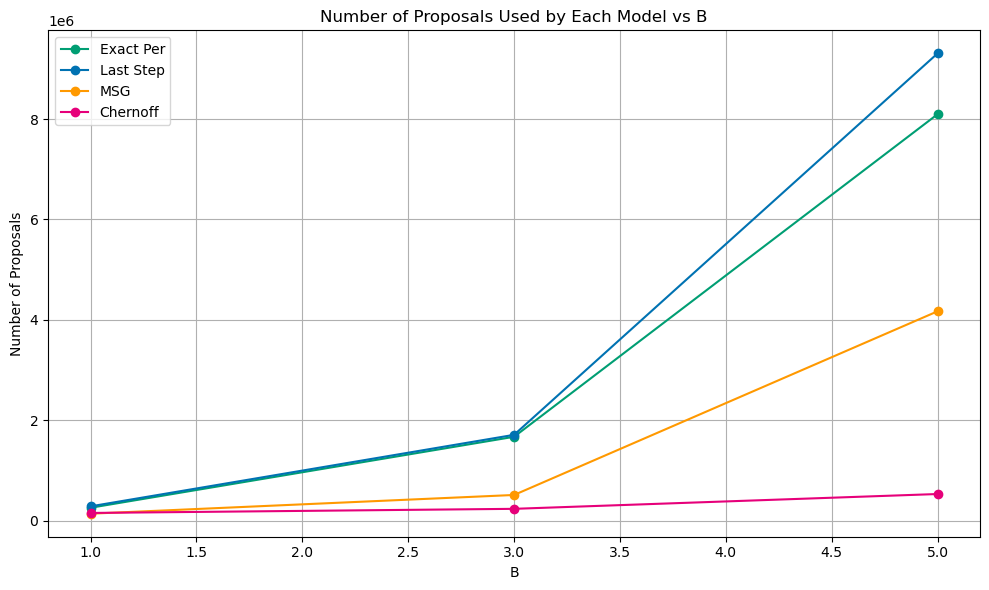

In [39]:
plt.figure(figsize=(10, 6))
Bs = sorted(results_loaded.keys())

# Map keys to y-values
plot_keys = [
    ("X_per",        [results_loaded[B]["num_steps_per"]   for B in Bs]),
    ("X_guided_last",[results_loaded[B]["num_steps_last"]  for B in Bs]),
    # ("X_guided_true",[results_loaded[B]["num_steps_true"]  for B in Bs]),  # Uncomment if you want to plot True
    ("X_guided_msg", [results_loaded[B]["num_steps_msg"]   for B in Bs]),
    ("X_guided_chern",[results_loaded[B]["num_steps_chern"] for B in Bs]),
]

for key, yvals in plot_keys:
    plt.plot(
        Bs, yvals, marker='o',
        label=guided_info[key]["label"],
        color=guided_info[key]["color"]
    )

plt.xlabel('B')
plt.ylabel('Number of Proposals')
plt.title('Number of Proposals Used by Each Model vs B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

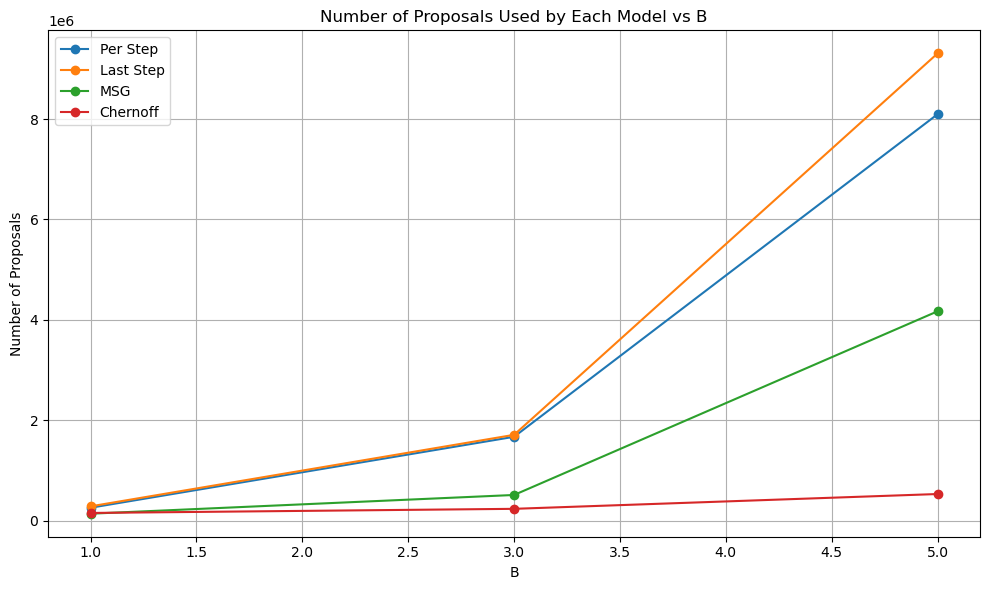

In [34]:
plt.figure(figsize=(10, 6))
Bs = sorted(results_loaded.keys())
num_steps_chern = [results_loaded[B]["num_steps_chern"] for B in Bs]
num_steps_per = [results_loaded[B]["num_steps_per"] for B in Bs]
num_steps_last = [results_loaded[B]["num_steps_last"] for B in Bs]
num_steps_true = [results_loaded[B]["num_steps_true"] for B in Bs]
num_steps_msg = [results_loaded[B]["num_steps_msg"] for B in Bs]

plt.plot(Bs, num_steps_per, marker='o', label='Per Step')
plt.plot(Bs, num_steps_last, marker='o', label='Last Step')
# plt.plot(Bs, num_steps_true, marker='o', label='True')
plt.plot(Bs, num_steps_msg, marker='o', label='MSG')
plt.plot(Bs, num_steps_chern, marker='o', label='Chernoff')

plt.xlabel('B')
plt.ylabel('Number of Proposals')
plt.title('Number of Proposals Used by Each Model vs B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(10, 6))
Bs = sorted(results_loaded.keys())
num_steps_per = [results_loaded[B]["num_steps_per"] for B in Bs]
num_steps_last = [results_loaded[B]["num_steps_last"] for B in Bs]
num_steps_true = [results_loaded[B]["num_steps_true"] for B in Bs]
num_steps_msg = [results_loaded[B]["num_steps_msg"] for B in Bs]

plt.plot(Bs, num_steps_per, marker='o', label='Per Step')
plt.plot(Bs, num_steps_last, marker='o', label='Last Step')
plt.plot(Bs, num_steps_true, marker='o', label='True')
plt.plot(Bs, num_steps_msg, marker='o', label='MSG')

plt.xlabel('B')
plt.ylabel('Number of Steps')
plt.title('Number of Steps Used by Each Model vs B')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(10, 6))
Bs = sorted(results_loaded.keys())
num_steps_per = [results_loaded[B]["num_steps_per"] for B in Bs]
num_steps_last = [results_loaded[B]["num_steps_last"] for B in Bs]
num_steps_true = [results_loaded[B]["num_steps_true"] for B in Bs]
num_steps_msg = [results_loaded[B]["num_steps_msg"] for B in Bs]

plt.plot(Bs, num_steps_per, marker='o', label='Per Step')
plt.plot(Bs, num_steps_last, marker='o', label='Last Step')
plt.plot(Bs, num_steps_true, marker='o', label='True')
plt.plot(Bs, num_steps_msg, marker='o', label='MSG')

plt.xlabel('B')
plt.ylabel('Number of Steps')
plt.title('Number of Steps Used by Each Model vs B')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax = plt.gca()

# Add inset for B=1
x1_idx = Bs.index(1)
x1 = Bs[x1_idx]
y1 = num_steps_per[x1_idx]
inset1 = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.05, 0.95, 1, 1), bbox_transform=ax.transAxes)
inset1.plot(Bs, num_steps_per, marker='o', label='Per Step')
inset1.plot(Bs, num_steps_last, marker='o', label='Last Step')
inset1.plot(Bs, num_steps_true, marker='o', label='True')
inset1.plot(Bs, num_steps_msg, marker='o', label='MSG')
inset1.set_xlim(x1-0.5, x1+0.5)
inset1.set_ylim(min(num_steps_per)-10, max(num_steps_per)+10)
inset1.set_xticks([x1])
inset1.set_title('Zoom at B=1')
mark_inset(ax, inset1, loc1=2, loc2=4, fc="none", ec="0.5")

# Add inset for B=5
x5_idx = Bs.index(5)
x5 = Bs[x5_idx]
y5 = num_steps_per[x5_idx]
inset5 = inset_axes(ax, width="30%", height="30%", loc='upper right', bbox_to_anchor=(0.95, 0.95, 1, 1), bbox_transform=ax.transAxes)
inset5.plot(Bs, num_steps_per, marker='o', label='Per Step')
inset5.plot(Bs, num_steps_last, marker='o', label='Last Step')
inset5.plot(Bs, num_steps_true, marker='o', label='True')
inset5.plot(Bs, num_steps_msg, marker='o', label='MSG')
inset5.set_xlim(x5-0.5, x5+0.5)
inset5.set_ylim(min(num_steps_per)-10, max(num_steps_per)+10)
inset5.set_xticks([x5])
inset5.set_title('Zoom at B=5')
mark_inset(ax, inset5, loc1=1, loc2=3, fc="none", ec="0.5")

plt.show()

In [ ]:
results_loaded